# p-value histrogram plots for two cases:

1) p-values as calculated via a permutation test 

2) p-values as calculated assuming that the null follows a chi-squared with one degree distribution



In [1]:
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
import matplotlib.lines as mlines
import pandas as pd
import scipy.stats as ss
import scipy as sc

In [12]:
df = pd.read_csv('results_mouseob_permuted.csv', index_col=0)
df2 = pd.read_csv('spatial_results_chisq.csv', index_col=0)
ll = df2['log_likelihood_ratio']
df3 = pd.read_csv('spatialde_res.csv', index_col=0)
llr_sde = df3['LLR']
pval_or = df2['pval']

In [3]:
df.sort_values(by=['log_likelihood_ratio'], inplace=True)
df

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value,g_sde,LLR_sde
gene_gpc,,,,,,,
Cox6c,-1124.904373,-819.175015,-305.729358,1.000000e+00,1.000000,Snx15,0.000964
Ubr3,-796.951887,-671.458858,-125.493029,1.000000e+00,1.000000,Rragd,0.000964
Rps14,-694.289770,-685.553645,-8.736125,1.000000e+00,1.000000,Fam126a,0.000964
Cyp2j12,-39.068012,-39.067047,-0.000965,1.000000e+00,1.000000,Hmga2,0.437059
2610307P16Rik,-37.902099,-37.901184,-0.000915,1.000000e+00,1.000000,Zfp945,0.250511
...,...,...,...,...,...,...,...
Trak2,-752.092167,-771.685043,19.592875,9.580000e-06,0.028478,Mfsd5,0.000964
Kctd12,-1109.957778,-1131.784096,21.826318,2.980000e-06,0.011088,Ccdc174,0.000964
Beta-s,-1117.092365,-1142.050943,24.958579,5.860000e-07,0.002901,Zfp84,1.420982


In [5]:
df2.sort_values(by=['log_likelihood_ratio'], inplace=True)

In [6]:
data_act = df2['log_likelihood_ratio'].to_numpy()
data_null = df['log_likelihood_ratio'].to_numpy()

In [7]:
position = []
for i in range(len(data_act)):
    for j in range(len(data_null)):

        if data_null[j]==data_act[i]:
            if data_null[j] == 0:
                position.append(j)
                break
            else:
                position.append(j-1)
                break      
        if data_null[j]>data_act[i]:
            position.append(j-1)
            break
        if j == len(data_null) - 1:
            position.append(j)

In [8]:
#(n-i)/n
p_value_list = []
for i in range(len(position)):
    p_value_list.append((len(data_null) - position[i])/ len(data_null))

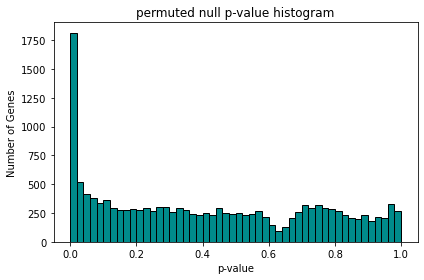

In [9]:
plt.hist(p_value_list, bins=50, color='darkcyan', ec='k');
plt.title('permuted null p-value histogram')
plt.ylabel('Number of Genes')
plt.xlabel('p-value');
plt.tight_layout()
# plt.savefig('pvalhistperm.pdf', dpi=100)

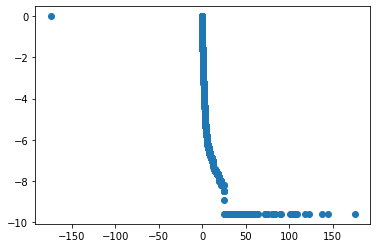

In [10]:
plt.scatter(data_act,np.log(p_value_list))

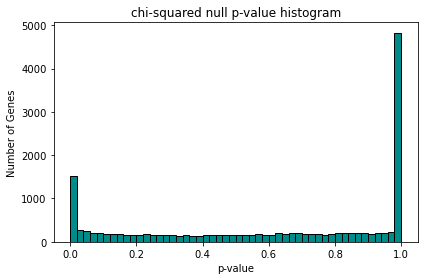

In [14]:
plt.hist(pval_or, bins=50, color='darkcyan', ec='k');
plt.title('chi-squared null p-value histogram')
plt.ylabel('Number of Genes')
plt.xlabel('p-value');
plt.tight_layout()

In [212]:
import scipy as sp
from scipy import interpolate
def qvalue(pv, pi0=None):
    '''
    Estimates q-values from p-values
    This function is modified based on https://github.com/nfusi/qvalue
    Args
    ====
    pi0: if None, it's estimated as suggested in Storey and Tibshirani, 2003.
    '''
    assert(pv.min() >= 0 and pv.max() <= 1), "p-values should be between 0 and 1"

    original_shape = pv.shape
    pv = pv.ravel()  # flattens the array in place, more efficient than flatten()

    m = float(len(pv))

    # if the number of hypotheses is small, just set pi0 to 1
    if len(pv) < 100 and pi0 is None:
        pi0 = 1.0
    elif pi0 is not None:
        pi0 = pi0
    else:
        # evaluate pi0 for different lambdas
        pi0 = []
        lam = sp.arange(0, 0.90, 0.01)
        counts = sp.array([(pv > i).sum() for i in sp.arange(0, 0.9, 0.01)])
        for l in range(len(lam)):
            pi0.append(counts[l]/(m*(1-lam[l])))

        pi0 = sp.array(pi0)

        # fit natural cubic spline
        tck = interpolate.splrep(lam, pi0, k=3)
        pi0 = interpolate.splev(lam[-1], tck)

        if pi0 > 1:
            pi0 = 1.0

    assert(pi0 >= 0 and pi0 <= 1), "pi0 is not between 0 and 1: %f" % pi0

    p_ordered = sp.argsort(pv)
    pv = pv[p_ordered]
    qv = pi0 * m/len(pv) * pv
    qv[-1] = min(qv[-1], 1.0)

    for i in range(len(pv)-2, -1, -1):
        qv[i] = min(pi0*m*pv[i]/(i+1.0), qv[i+1])

    # reorder qvalues
    qv_temp = qv.copy()
    qv = sp.zeros_like(qv)
    qv[p_ordered] = qv_temp

    # reshape qvalues
    qv = qv.reshape(original_shape)

    return qv


In [213]:
pval = pd.Series(p_value_list)
df2['qvalue_permuted'] = qvalue(pval)
df2

/Users/user/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
/Users/user/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
/Users/user/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
/Users/user/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
/Users/user/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.argsort is deprecated and will be removed in SciPy 2.0.0, use numpy.argsort instead
/Users/user/opt/anacon

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,lengthscale,Unnamed: 5,pval,q value,BIC_periodic,BIC_linear,BIC_rbf,qvalue_permuted
Atp1b2,-1016.227626,-841.977304,-174.250322,2.592762,NaN,1.0,1.0,1697.089426,1691.528740,2054.697979,0.808203
Prss48,-16.907008,-16.652417,-0.254592,7.692128,NaN,1.0,1.0,55.547560,49.986878,56.056744,0.808149
Gabrr2,-25.872195,-25.637627,-0.234568,2.268529,NaN,1.0,1.0,79.210680,73.649998,73.987116,0.808149
Wdr62,-45.502643,-45.501741,-0.000902,0.875815,NaN,1.0,1.0,113.246206,107.685525,113.248013,0.808149
Gas2l2,-56.111572,-56.110757,-0.000814,0.359540,NaN,1.0,1.0,134.464242,128.903561,134.465870,0.808149
...,...,...,...,...,...,...,...,...,...,...,...
Scd1,-887.377675,-1005.961963,118.584288,2.020826,NaN,0.0,0.0,2034.166642,2028.605970,1796.998077,0.004958
Kif5b,-852.911832,-975.895594,122.983762,1.641483,NaN,0.0,0.0,1974.033914,1968.473250,1728.066392,0.004958
Apoe,-1380.773688,-1518.292602,137.518914,2.299816,NaN,0.0,0.0,3058.828824,3053.268140,2783.790103,0.004958
Apod,-1120.543036,-1265.301416,144.758380,1.689753,NaN,0.0,0.0,2552.846733,2547.286150,2263.328799,0.004958
